In [1]:
!pip install lxml
!apt install fonts-ipafont-gothic
!rm /content/.cache/matplotlib/fontList.json

    100% |████████████████████████████████| 5.7MB 5.2MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 0 not upgraded.
Need to get 8,248 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/universe amd64 fonts-ipafont-gothic all 00303-17ubuntu1 [3,523 kB]
Get:2 http://archive.ubuntu.com/ubuntu artful/universe amd64 fonts-ipafont-mincho all 00303-17ubuntu1 [4,725 kB]
Fetched 8,248 kB in 1s (7,152 kB/s)

78Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-17ubuntu1_all.deb ...
7Progress: [  0%] [...................

In [0]:
import csv
import time
from urllib.parse import urljoin

import requests
from bs4 import BeautifulSoup


def scraping(n, url):

    r = requests.get(url)

    if r.status_code == requests.codes.ok:

        soup = BeautifulSoup(r.content, 'html5lib')

        # シーズン・節
        score_season = soup.select_one(
            'div.score-header > h2.score-meta > span.score-season').get_text(
                strip=True).split()

        # print(score_season)

        # 日時
        score_date = soup.select_one(
            'div.score-header > h2.score-meta > span.score-date').get_text(
                strip=True).split()

        # print(score_date)

        score_table = soup.select_one('table.score-table')

        home_team = score_table.select_one('th.score-team1').get_text(
            strip=True)
        away_team = score_table.select_one('th.score-team2').get_text(
            strip=True)

        # print(home_team, away_team)

        score_finish = [
            int(i.get_text(strip=True))
            for i in score_table.select('td.score-finish')
        ]

        # print(score_finish)

        score_part = [
            int(i.get_text(strip=True))
            for i in score_table.select('td.score-part')
            if i.get_text(strip=True) not in ['前半', '後半']
        ]

        # print(score_part)

        game_info = [
            td.get_text(strip=True) for td in soup.select(
                'div.score-frame-other > div.score-right > table > tbody > tr > td'
            )
        ]

        # 節
        score_season[1] = score_season[1].strip('第節')

        # 観客
        game_info[0] = game_info[0].rstrip('人').replace(',', '')

        # 気温
        game_info[2] = game_info[2].rstrip('℃')

        # print(game_info)

        result = [n] + score_season + score_date + [
            home_team, away_team
        ] + score_finish + score_part + game_info

        return (result)


if __name__ == "__main__":

    url = 'http://www.jfl.or.jp/jfl-pc/view/s.php?a=1270&f=2018A001_spc.html'

    r = requests.get(url)

    if r.status_code == requests.codes.ok:

        soup = BeautifulSoup(r.content, 'html5lib')

        with open('result.csv', 'w') as fw:
            writer = csv.writer(fw, dialect='excel', lineterminator='\n')
            writer.writerow([
                '試合', 'ステージ', '節', '日付', '時刻', 'ホーム', 'アウェイ', '合計H', '合計A',
                '前半H', '前半A', '後半H', '後半A', '観客', '天候', '気温', '湿度', '風',
                'ピッチ状態'
            ])

            n = 0

            for link in soup.select('td.detail-link > a'):

                # 詳細のリンクか確認
                if link.text == '詳細':

                    n += 1

                    spc_url = urljoin(url, link.get('href'))

                    # 詳細をスクレイピング
                    result = scraping(n, spc_url)

                    writer.writerow(result)

                    # 1秒待機
                    time.sleep(1)


In [2]:
import pandas as pd

df = pd.read_csv('result.csv')
df.head()

,試合,ステージ,節,日付,時刻,ホーム,アウェイ,合計H,合計A,前半H,前半A,後半H,後半A,観客,天候,気温,湿度,風,ピッチ状態
0,1,ファーストステージ,1,2018年03月11日(日),13:00,Ｈｏｎｄａ ＦＣ,コバルトーレ女川,2,1,1,0,1,1,1311,晴,15.0,26%,強,全面良芝、乾燥
1,2,ファーストステージ,1,2018年03月11日(日),13:00,ＦＣ大阪,ヴィアティン三重,3,1,1,1,2,0,1378,晴,14.7,37%,強,良芝、乾燥
2,3,ファーストステージ,1,2018年03月11日(日),13:00,ＦＣ今治,ヴェルスパ大分,4,1,0,0,4,1,4493,晴,19.8,34%,弱,全面良芝、乾燥
3,4,ファーストステージ,1,2018年03月11日(日),13:00,奈良クラブ,テゲバジャーロ宮崎,1,0,1,0,0,0,2271,晴,14.6,36%,中,全面良芝、乾燥
4,5,ファーストステージ,1,2018年03月11日(日),13:00,ホンダロックＳＣ,ＦＣマルヤス岡崎,2,2,0,2,2,0,386,晴,14.8,52%,弱,良芝、乾燥


In [0]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'IPAPGothic'

In [4]:
pv = df.pivot_table(values = '観客', index = '節', columns='ホーム', aggfunc = sum)
pv.T

節,1,2,3,4,5,6,7,8,9,10,11,12
ホーム,,,,,,,,,,,,
コバルトーレ女川,NaN,NaN,NaN,1313.0,NaN,NaN,417.0,NaN,657.0,NaN,312.0,NaN
ソニー仙台ＦＣ,NaN,1006.0,NaN,541.0,NaN,347.0,NaN,654.0,NaN,346.0,NaN,212.0
テゲバジャーロ宮崎,NaN,675.0,NaN,466.0,NaN,831.0,NaN,418.0,NaN,380.0,NaN,NaN
ホンダロックＳＣ,386.0,235.0,256.0,NaN,325.0,NaN,302.0,NaN,314.0,NaN,271.0,NaN
ラインメール青森,NaN,NaN,NaN,NaN,NaN,NaN,566.0,NaN,1337.0,358.0,328.0,695.0
ヴァンラーレ八戸,NaN,2902.0,NaN,2016.0,NaN,1107.0,NaN,1123.0,NaN,2009.0,NaN,2606.0
ヴィアティン三重,NaN,1187.0,NaN,755.0,NaN,594.0,NaN,781.0,1133.0,NaN,608.0,NaN
ヴェルスパ大分,NaN,702.0,NaN,1085.0,451.0,236.0,NaN,NaN,362.0,NaN,262.0,NaN
奈良クラブ,2271.0,NaN,1317.0,NaN,994.0,1021.0,NaN,2006.0,NaN,2012.0,NaN,NaN


In [5]:
pv_imabari = pv['ＦＣ今治'].dropna(how='all')
pv_imabari

節
1     4493.0
3     2953.0
5     2731.0
7     3152.0
9     2908.0
10    2489.0
12    2401.0
Name: ＦＣ今治, dtype: float64

In [6]:
pv_imabari.agg(['count', 'mean', 'std', 'min', 'median', 'max', 'sum'])

count         7.000000
mean       3018.142857
std         701.522732
min        2401.000000
median     2908.000000
max        4493.000000
sum       21127.000000
Name: ＦＣ今治, dtype: float64

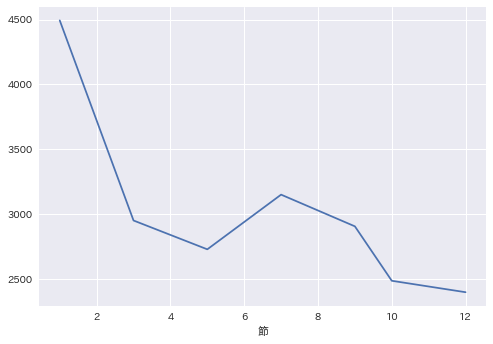

In [7]:
pv_imabari.plot()

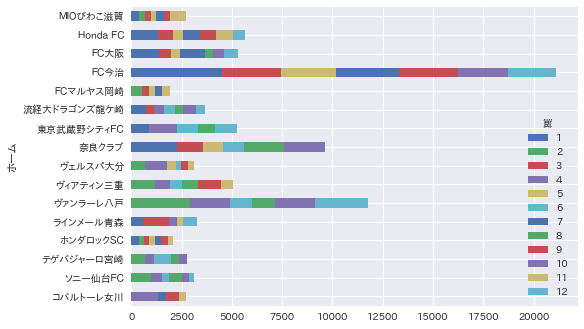

In [8]:
pv.T.plot.barh(stacked=True)

In [9]:
pv_desc = pv.agg(['count', 'mean', 'min', 'max', 'sum']).T
pv_desc['rank'] = pv_desc['sum'].rank(ascending=False, method='min')
pv_desc.sort_values('rank', inplace=True)
pv_desc.reset_index(inplace=True)
pv_desc.set_index('rank', inplace=True)
pv_desc

,index,count,mean,min,max,sum
rank,,,,,,
1.0,ＦＣ今治,7.0,3018.142857,2401.0,4493.0,21127.0
2.0,ヴァンラーレ八戸,6.0,1960.500000,1107.0,2902.0,11763.0
3.0,奈良クラブ,6.0,1603.500000,994.0,2271.0,9621.0
4.0,Ｈｏｎｄａ ＦＣ,7.0,805.714286,489.0,1311.0,5640.0
5.0,ＦＣ大阪,7.0,761.000000,403.0,1378.0,5327.0
6.0,東京武蔵野シティＦＣ,5.0,1056.000000,819.0,1413.0,5280.0
7.0,ヴィアティン三重,6.0,843.000000,594.0,1187.0,5058.0
8.0,流経大ドラゴンズ龍ケ崎,7.0,521.000000,381.0,727.0,3647.0
9.0,ラインメール青森,5.0,656.800000,328.0,1337.0,3284.0
